### Sentiment analysis on polish press articles (unsupervised learning)



The original idea of the analysis was to analyze the sentiment of articles in Polish about the CD Project company. This is an original data set, scraped from several websites of legal press sources. We have no information about their sentiment, so there is no label. Moreover, the press language is quite unified - it is not very emotionally charged. So there is no guarantee that there will be such a sentiment.
I also have quite basic experience in processing and working with text, so selecting parameters for algorithms will be quite intuitive.


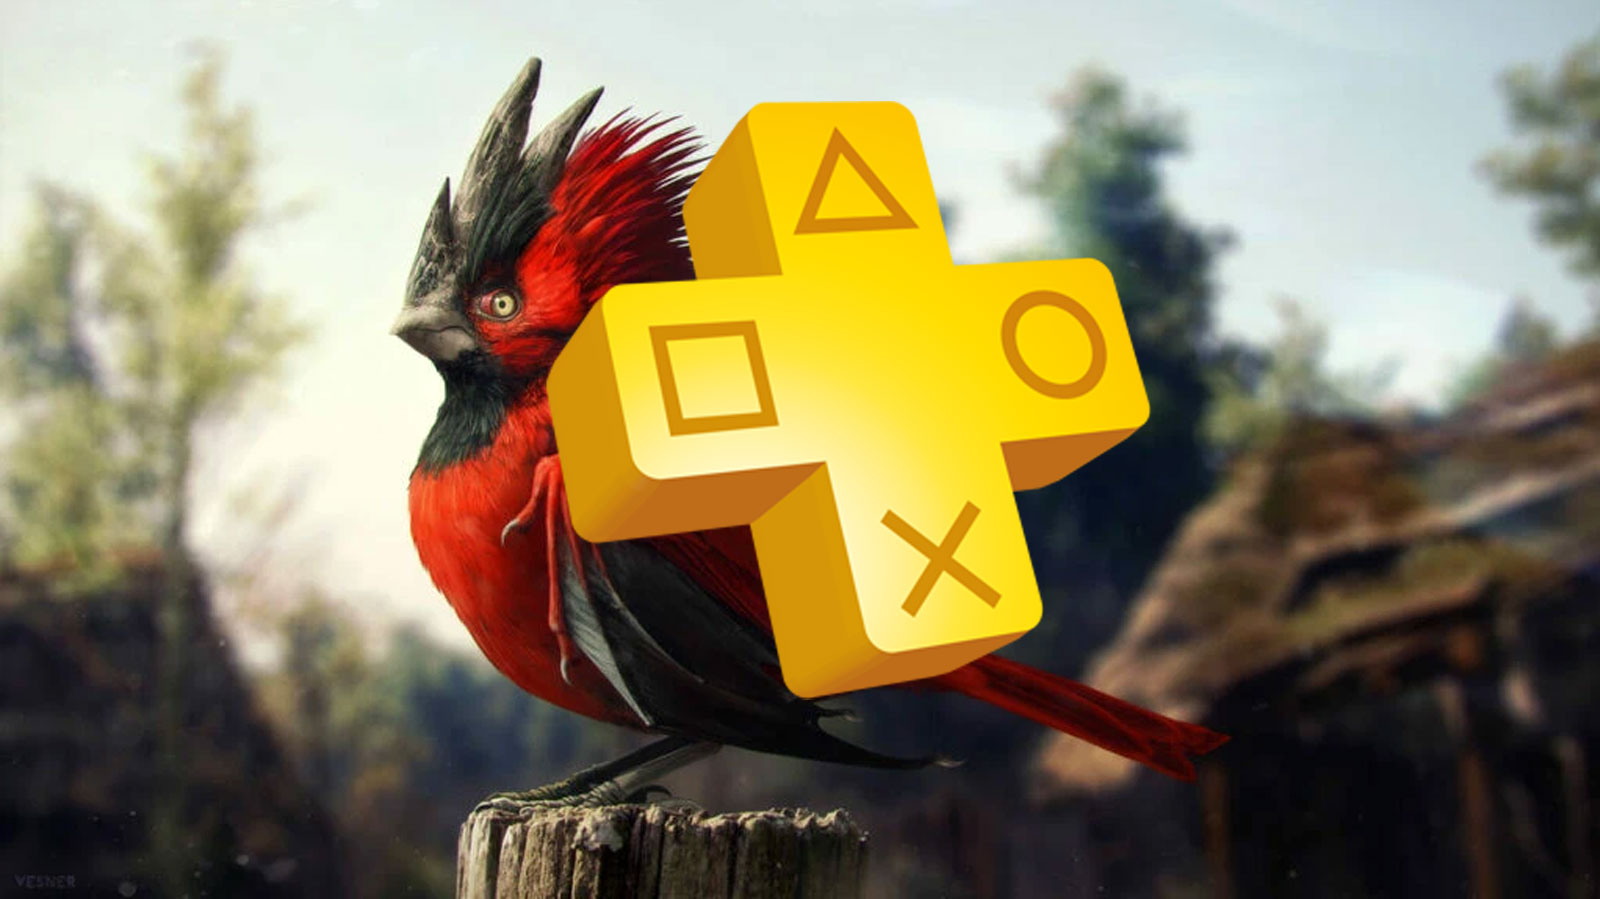




When trying to work with articles, I was inspired by the following repositories:


https://github.com/rafaljanwojcik/Unsupervised-Sentiment-Analysis/blob/master/Predictions.ipynb


https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/unsupervised_sentiment_analysis.py


oraz:

https://ermlab.com/en/blog/nlp/polish-sentiment-analysis-using-keras-and-word2vec/


In [139]:
!pip install unidecode

In [140]:
import re
import logging
import numpy as np
import pandas as pd
import multiprocessing

from re import sub
from time import time
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [141]:
file = pd.read_excel("dane_cdproject.xlsx")
file_cleaned = file.dropna().drop_duplicates().reset_index(drop=True).rename(columns={'description':'title'})
#dodanie kolumny rate do struktury - ulatwienie pracy z kodem z repozytorium r.wojcika
file_cleaned['rate'] = 1

In [142]:
file_cleaned.rate.value_counts()/len(file_cleaned)

1    1.0
Name: rate, dtype: float64

In [143]:
def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = remove_polish_letters(text)
    text = str(text)
    text = text.lower()

    # czyszczenie tekstu
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [144]:
file_cleaned.text = file_cleaned.text.apply(lambda x: text_to_word_list(x, unidecode))

In [145]:
file_model = file_cleaned.copy()
file_model = file_model[file_model.text.str.len()>1]

In [146]:
sent = [row for row in file_model.text]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

['firma',
 'capcom',
 'udostepnila',
 'aktualizacje',
 'monster_hunter',
 'world',
 'dzieki',
 'ktorej',
 'do',
 'gry',
 'trafila',
 'postac',
 'geralt',
 'z',
 'rivii',
 'znanego',
 'z',
 'gier',
 'stworzonych',
 'przez',
 'studio',
 'cd_projekt',
 'red',
 'a',
 'takze',
 'ksiazek',
 'andrzeja_sapkowskiego',
 'inspirowana',
 'gra',
 'wiedzmin_3',
 'dziki_gon',
 'dodatkowa',
 'zawartosc',
 'monster_hunter',
 'world',
 'dostepna',
 'jest',
 'na',
 'konsolach_playstation',
 '4_oraz',
 'xbox_one',
 'w_formie',
 'darmowej',
 'aktualizacji',
 'na_pc',
 'aktualizacja',
 'ukaze_sie',
 'w',
 'pozniejszym',
 'terminie',
 'za',
 'goscinne',
 'wystepy',
 'geralta',
 'cd_projekt',
 'nie',
 'otrzyma',
 'zadnego',
 'wynagrodzenia',
 'obecnosc',
 'geralta',
 'w',
 'monster_hunter',
 'world',
 'jest',
 'zwiazana',
 'ze',
 'specjalnym',
 'nieodplatnym',
 'wydarzeniem',
 'fabularnym',
 'zaoferowanym',
 'graczom',
 'przez',
 'capcom',
 'cd_projekt',
 'nie',
 'otrzymuje',
 'z',
 'tego',
 'tytulu',
 'zadny

In [147]:
w2v_model = Word2Vec(min_count=2,
                     window=3,
                     vector_size=3000,
                     sample=1e-5,
                     alpha=0.05,
                     min_alpha=0.0007,
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.0 mins


In [ ]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

In [149]:
w2v_model.save("word2vec.model")

In [150]:
file_export = file_model.copy()
file_export['old_text'] = file_export.text
file_export.old_text = file_export.old_text.str.join(' ')
file_export.text = file_export.text.apply(lambda x: ' '.join(bigram[x]))
file_export.rate = file_export.rate.astype('int8')

In [151]:
file_export[['text', 'rate']].to_csv('cleaned_dataset.csv', index=False)

In [152]:
from sklearn.cluster import KMeans

In [153]:
word_vectors = Word2Vec.load("word2vec.model").wv

In [154]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [155]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('oceny', 1.0),
 ('ponad_400', 0.9468963742256165),
 ('co', 0.9468435049057007),
 ('jednoczesnie', 0.9468392133712769),
 ('w_kinie', 0.946821928024292),
 ('ponad_20', 0.9468169212341309),
 ('postaci_johnny', 0.9467936754226685),
 ('poza', 0.9467926621437073),
 ('rok', 0.9467916488647461),
 ('promocji', 0.9467781782150269)]

In [156]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [157]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [158]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

<ipython-input-158-652cc92ca545>:2: RuntimeWarning: divide by zero encountered in double_scalars
  words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)


In [159]:
words.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,na,"[0.019407446, -0.02680152, 0.017406505, 0.0071...",0,-1,357.621328,-357.621328
1,w,"[0.019416941, -0.026793716, 0.017363736, 0.007...",0,-1,330.870797,-330.870797
2,i,"[0.019451667, -0.026886677, 0.01741119, 0.0071...",0,-1,397.769960,-397.769960
3,jest,"[0.019505963, -0.026828911, 0.017322507, 0.007...",0,-1,267.318810,-267.318810
4,sie,"[0.019578757, -0.02687019, 0.017421847, 0.0070...",0,-1,187.613614,-187.613614
5,z,"[0.019475343, -0.026719902, 0.017447721, 0.007...",0,-1,234.740246,-234.740246
6,ze,"[0.019363789, -0.026833706, 0.017409483, 0.007...",0,-1,289.182043,-289.182043
7,to,"[0.019540202, -0.026805043, 0.017318264, 0.007...",0,-1,235.794244,-235.794244
8,do,"[0.019391378, -0.02677799, 0.017400255, 0.0069...",0,-1,214.462888,-214.462888
9,nie,"[0.019375576, -0.02682454, 0.017482687, 0.0070...",0,-1,197.903996,-197.903996


In [160]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [161]:
#Predykcja
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [162]:
final_file = pd.read_csv('cleaned_dataset.csv')

In [163]:
sentiment_map = pd.read_csv('sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [164]:
file_weighting = final_file.copy()

In [165]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.text)
features = pd.Series(tfidf.get_feature_names_out())
transformed = tfidf.transform(file_weighting.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [166]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score

    inspired  by function from this wonderful article:
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)
    return list(map(lambda y:dictionary[f'{y}'], x.text.split()))

In [167]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 21.6 ms


In [168]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [169]:
replaced_closeness_scores = file_weighting.text.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [170]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.text, file_weighting.rate]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence', 'sentiment']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i==1 else 0 for i in replacement_df.sentiment]

In [171]:
predicted_classes = replacement_df.prediction
y_test = replacement_df.sentiment

conf_matrix = pd.DataFrame(confusion_matrix(replacement_df.sentiment, replacement_df.prediction))
print('Confusion Matrix')
display(conf_matrix)

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)

Confusion Matrix


,0,1
0,0,0
1,20,2



 
 Scores


,scores
accuracy,0.090909
precision,1.000000
recall,0.090909
f1,0.166667


Ultimately, the model cannot be considered working.

The following steps were performed sequentially: data cleaning, vectorization, adding sentiment to words and clustering, which was to collect the data into two clusters (positive and negative sentiment). In the last step, predictions were made.

While it was obvious that analysis on such data may be "risky", it is worth noting that several other attempts can be made to work with such data:

- use of ready-made models related to sentiment. This analysis is currently ongoing

- better parameterization of the solution

- selecting an algorithm other than the very basic kmeans